In [1]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import pandas as pd
import pickle

pd.options.display.float_format = '{:,.2f}'.format

Populating the interactive namespace from numpy and matplotlib


In [2]:
with open(f'../data/joined_df','rb') as read_file:
    joined_df = pickle.load(read_file)

Keep the higher budget from either data source

In [3]:
joined_df['budget'] = joined_df['budget'].fillna(0)
joined_df['budget'] = joined_df['budget'].astype(int)

joined_df['tn_budget'] = joined_df['tn_budget'].fillna(0)
joined_df['tn_budget'] = joined_df['tn_budget'].astype(int)

joined_df['corrected_budget'] = joined_df[['budget','tn_budget']].max(axis=1)

In [4]:
joined_df['release_duration'] = joined_df['release_duration'].str.replace(r',', '')
joined_df['release_duration'] = joined_df['release_duration'].astype(int)

In [5]:
joined_df = joined_df[joined_df.season.notna()]
joined_df = joined_df[joined_df.genre.notna()]
joined_df = joined_df[joined_df.rating.notna()]
joined_df = joined_df[joined_df.domestic_gross.notna()]
joined_df = joined_df[joined_df.corrected_budget > 0]
joined_df = joined_df[joined_df.distributor != '']

In [6]:
joined_df['domestic_gross'] = joined_df['domestic_gross'].fillna(0)
joined_df['domestic_gross'] = joined_df['domestic_gross'].astype(int)

In [7]:
top_studios_df = joined_df.groupby(['distributor'], as_index=False).domestic_gross.mean().sort_values('domestic_gross', ascending=False)
top_studios_set = set(top_studios_df.iloc[:50].distributor)
joined_df = joined_df[joined_df.distributor.isin(top_studios_set)]

In [8]:
joined_df = joined_df.drop(['title', 'budget', 'tn_title', 'release_date',  'release_year', 'tn_release_date', 'tn_release_year', 'tn_budget', 'rank', 'movie_id'], axis = 1)

In [9]:
joined_df = joined_df.rename(columns={'corrected_budget': 'budget'})
joined_df = joined_df.reset_index(drop=True)

In [10]:
drop_list = ['domestic_gross', 'distributor', 'rating','season', 'genre']
target = ['domestic_gross']

# Dummy features

In [11]:
def dummy_feature_to_dataframe(feature, df):
    return pd.concat([df, df[feature].str.get_dummies()], axis = 1).drop(feature, 1)

In [12]:
def score_df(df):
    training_df = df[148:]
    test_df = df[:148]

    X_train = training_df[training_df.columns.difference(drop_list)]
    y_train = training_df[target]

    X_test = test_df[test_df.columns.difference(drop_list)]
    y_test = test_df[target]

    m = LinearRegression()
    m.fit(X_train,y_train)
    m.score(X_train,y_train)
    return m.score(X_test,y_test)

In [13]:
score_df(joined_df)

0.48172087715092493

In [14]:
rating_df = dummy_feature_to_dataframe('rating', joined_df)
rating_df.head(5)

,domestic_gross,distributor,genre,release_duration,season,budget,G,PG,PG-13,R
0,858373000,Walt Disney Studios Motion Pictures,"Action,Adventure,Drama,Sci-Fi",250,spring,400000000,0,0,1,0
1,543638043,Walt Disney Studios Motion Pictures,"Adventure,Animation,Drama,Family,Musical",168,summer,260000000,0,1,0,0
2,434038008,Walt Disney Studios Motion Pictures,"Adventure,Animation,Comedy,Family,Fantasy",196,summer,200000000,1,0,0,0
3,477373578,Walt Disney Studios Motion Pictures,"Adventure,Animation,Comedy,Family,Fantasy,Musical",423,holiday,150000000,0,1,0,0
4,426829839,Walt Disney Studios Motion Pictures,"Action,Adventure,Sci-Fi",299,spring,175000000,0,0,1,0


In [15]:
score_df(rating_df)

0.48105152673555307

In [16]:
rating_df.corr()

,domestic_gross,release_duration,budget,G,PG,PG-13,R
domestic_gross,1.00,0.17,0.69,0.09,0.12,0.14,-0.25
release_duration,0.17,1.00,0.09,0.03,0.07,0.05,-0.10
budget,0.69,0.09,1.00,0.12,0.13,0.23,-0.35
G,0.09,0.03,0.12,1.00,-0.04,-0.07,-0.07
PG,0.12,0.07,0.13,-0.04,1.00,-0.38,-0.37
PG-13,0.14,0.05,0.23,-0.07,-0.38,1.00,-0.71
R,-0.25,-0.10,-0.35,-0.07,-0.37,-0.71,1.00


In [17]:
season_df = dummy_feature_to_dataframe('season', joined_df)
season_df.head(5)

,domestic_gross,distributor,rating,genre,release_duration,budget,fall,holiday,spring,summer,winter
0,858373000,Walt Disney Studios Motion Pictures,PG-13,"Action,Adventure,Drama,Sci-Fi",250,400000000,0,0,1,0,0
1,543638043,Walt Disney Studios Motion Pictures,PG,"Adventure,Animation,Drama,Family,Musical",168,260000000,0,0,0,1,0
2,434038008,Walt Disney Studios Motion Pictures,G,"Adventure,Animation,Comedy,Family,Fantasy",196,200000000,0,0,0,1,0
3,477373578,Walt Disney Studios Motion Pictures,PG,"Adventure,Animation,Comedy,Family,Fantasy,Musical",423,150000000,0,1,0,0,0
4,426829839,Walt Disney Studios Motion Pictures,PG-13,"Action,Adventure,Sci-Fi",299,175000000,0,0,1,0,0


In [18]:
score_df(season_df)

0.4852412373652729

In [19]:
genre_df = pd.concat([joined_df, joined_df['genre'].str.get_dummies(sep=',')], axis = 1).drop('genre', 1)
genre_df.head(5)

,domestic_gross,distributor,rating,release_duration,season,budget,Action,Adventure,Animation,Biography,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,858373000,Walt Disney Studios Motion Pictures,PG-13,250,spring,400000000,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,543638043,Walt Disney Studios Motion Pictures,PG,168,summer,260000000,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
2,434038008,Walt Disney Studios Motion Pictures,G,196,summer,200000000,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,477373578,Walt Disney Studios Motion Pictures,PG,423,holiday,150000000,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
4,426829839,Walt Disney Studios Motion Pictures,PG-13,299,spring,175000000,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [20]:
score_df(genre_df)

0.5057424192086124

In [21]:
gen_corr = genre_df.corr()

In [22]:
rating_and_season_df = dummy_feature_to_dataframe('season', rating_df)
rating_and_season_df.head(5)

,domestic_gross,distributor,genre,release_duration,budget,G,PG,PG-13,R,fall,holiday,spring,summer,winter
0,858373000,Walt Disney Studios Motion Pictures,"Action,Adventure,Drama,Sci-Fi",250,400000000,0,0,1,0,0,0,1,0,0
1,543638043,Walt Disney Studios Motion Pictures,"Adventure,Animation,Drama,Family,Musical",168,260000000,0,1,0,0,0,0,0,1,0
2,434038008,Walt Disney Studios Motion Pictures,"Adventure,Animation,Comedy,Family,Fantasy",196,200000000,1,0,0,0,0,0,0,1,0
3,477373578,Walt Disney Studios Motion Pictures,"Adventure,Animation,Comedy,Family,Fantasy,Musical",423,150000000,0,1,0,0,0,1,0,0,0
4,426829839,Walt Disney Studios Motion Pictures,"Action,Adventure,Sci-Fi",299,175000000,0,0,1,0,0,0,1,0,0


In [23]:
temp = score_df(rating_and_season_df)
temp

0.48419564791750347

In [24]:
# sns.heatmap(rating_and_season_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [25]:
# training_df = joined_df[162:]
# test_df = joined_df[:162]

# training_X = training_df[training_df.columns.difference(drop_list)]
# training_y = training_df[target]

# X_train, X_test, y_train, y_test = train_test_split(joined_X, joined_y, test_size=0.2, random_state=42)

# m = LinearRegression()
# m.fit(training_X,training_y)
# m.score(training_X,training_y)
# m.score(X_test,y_test)

# m.score(test_df[test_df.columns.difference(drop_list)],test_df[target])

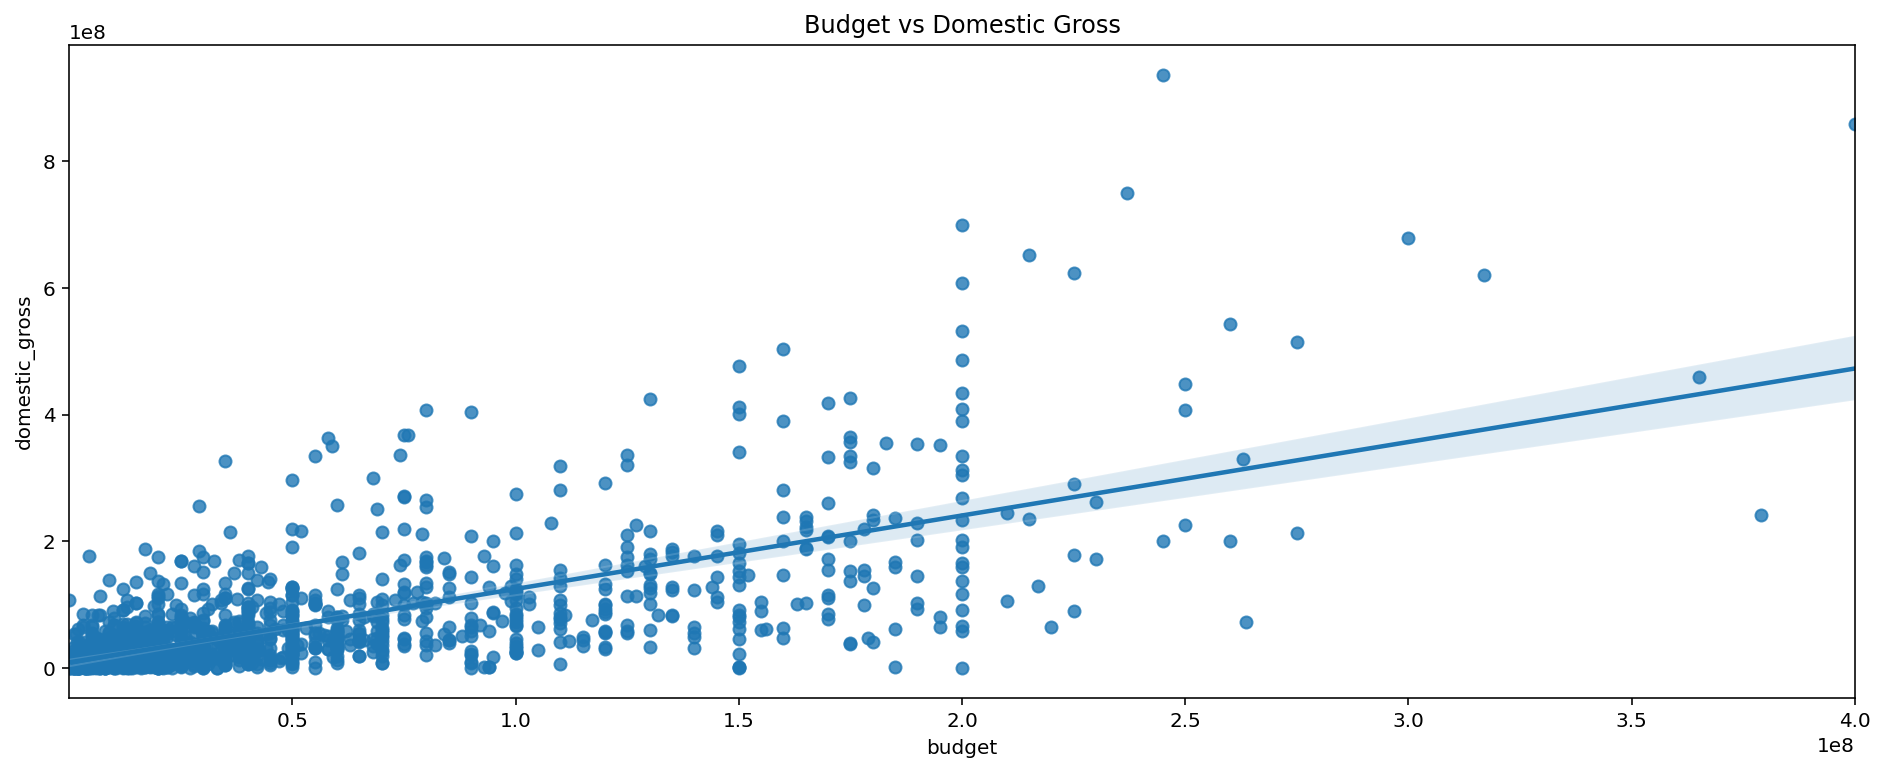

In [26]:
fig_dims = (16, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set_theme(color_codes=True)
sns_plot = sns.regplot(x="budget", y="domestic_gross", data=joined_df).set_title("Budget vs Domestic Gross")
plt.savefig("output.png")
# plt.savefig("output.svg", format='svg');